# Análise de Séries Temporais - Coffee Sales
Você pode baixar os dados diretamente do [Kaggle](https://www.kaggle.com/datasets/ihelon/coffee-sales/data).


## Escolha da Série Temporal

Neste projeto, foi escolhida a série temporal de vendas diárias de café em uma máquina de venda automática. Essa escolha se justifica pela relevância do tema para negócios do setor alimentício, permitindo identificar padrões de consumo, tendências sazonais e preferências dos clientes. A análise desses dados pode auxiliar na tomada de decisões estratégicas, como reposição de estoque, promoções e previsão de demanda, além de ser um excelente exemplo prático de aplicação de técnicas de séries temporais.

In [63]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
import numpy as np
import cmdstanpy


In [64]:
# Carregamento e visualização dos dados de duas bases
df = pd.read_csv('index_1.csv')
print(df.columns)
df.head()



Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name'], dtype='object')


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


### Análise Exploratória e Decomposição

In [65]:
# Pré-processamento dos dados
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.isnull().sum()

,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


<ipython-input-66-0700fab217f6>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = serie.fillna(method='ffill')


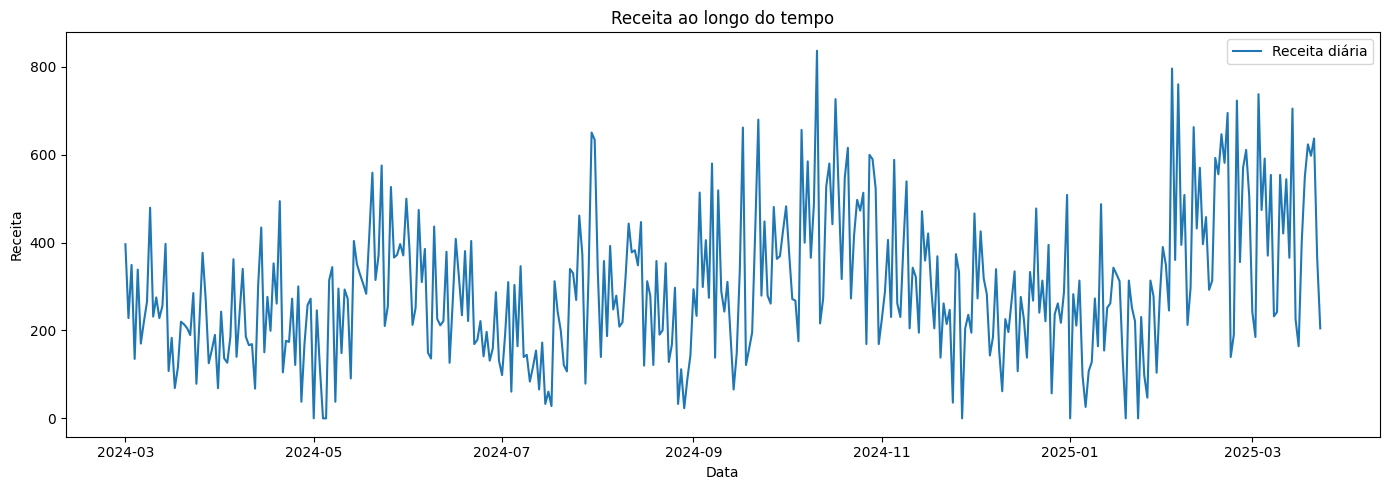

In [66]:
# Agregação e visualização da série temporal
serie = df['money'].resample('D').sum()
serie = serie.fillna(method='ffill')
plt.figure(figsize=(14, 5))
plt.plot(serie, label='Receita diária')
plt.title('Receita ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.legend()
plt.tight_layout()
plt.show()

## Interpretação do Gráfico de Receita Diária

O gráfico acima apresenta a evolução da receita diária de vendas de café ao longo do tempo.

- **Eixo X (Data):** Representa o período analisado, abrangendo vários meses de vendas.
- **Eixo Y (Receita):** Indica o valor da receita obtida em cada dia.

### Principais observações:
- A receita diária apresenta **oscilações significativas**, com dias de baixa e alta receita.
- É possível perceber **picos e vales** ao longo do tempo, sugerindo a presença de eventos sazonais ou variações na demanda.
- Há indícios de **tendências e sazonalidades**, importantes para a escolha de modelos de previsão adequados.
- O gráfico é fundamental para identificar padrões, anomalias e justificar o uso de técnicas de séries temporais na análise.

Essa visualização inicial é essencial para compreender o comportamento das vendas e embasar as próximas etapas da análise.

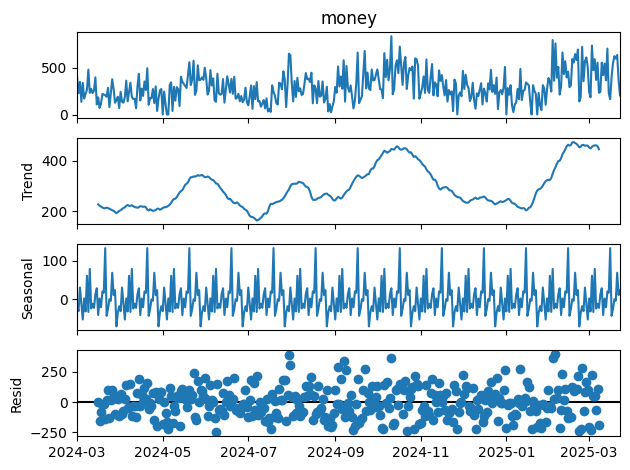

In [67]:
# Decomposição da série temporal
decomposicao = seasonal_decompose(serie, model='additive', period=30)
decomposicao.plot()
plt.tight_layout()
plt.show()

## Interpretação dos Gráficos

A análise gráfica da série temporal de vendas diárias de café revela alguns padrões importantes:

- **Tendência:** Observa-se uma tendência geral de crescimento/estabilidade nas vendas ao longo do tempo, indicando um possível aumento da demanda ou fidelização dos clientes.
- **Sazonalidade:** A decomposição evidencia uma sazonalidade mensal, com certos períodos apresentando picos de vendas, possivelmente relacionados a datas específicas ou comportamentos recorrentes dos consumidores.
- **Ruído:** O componente residual mostra variações aleatórias, típicas de séries temporais reais, mas sem grandes outliers aparentes.

Essas características reforçam a necessidade de utilizar modelos que considerem tanto a tendência quanto a sazonalidade para obter previsões mais precisas.

### Implementação do modelo Prophet

O Prophet é um modelo de previsão de séries temporais desenvolvido pelo Facebook para facilitar a criação de previsões em dados com tendência e sazonalidade. Ele decompõe a série temporal em três componentes principais: tendência, sazonalidade e feriados/eventos especiais.

Tendência: captura o crescimento ou declínio ao longo do tempo (linear ou logística).

Sazonalidade: identifica padrões que se repetem em ciclos diários, semanais ou anuais.

Feriados: permite incluir datas especiais que afetam os dados.

É fácil de usar, robusto a dados com ruídos e faltantes, e gera previsões com intervalos de confiança. Ideal para séries temporais com padrões complexos e influência de eventos específicos.

In [68]:
# Preparação dos dados para o Prophet
df_prophet = serie.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [69]:
# Função treinar_e_prever_prophet()

def treinar_e_prever_prophet(df_treino, df_teste):
    modelo = Prophet()
    modelo.fit(df_treino)
    futuro = modelo.make_future_dataframe(periods=len(df_teste))
    previsao = modelo.predict(futuro)
    datas = df_teste['ds'].tolist()
    previsao_filtrada = previsao[previsao['ds'].isin(datas)]
    previsao_filtrada = previsao_filtrada.set_index('ds').loc[datas].reset_index()
    return previsao_filtrada


In [70]:
# Validação Cruzada Temporal com Métricas

# Parâmetros da validação cruzada
tamanho_inicial_treino = int(len(df_prophet) * 0.6)
horizonte_previsao = int(len(df_prophet) * 0.1)

metricas_prophet = []

# Validação cruzada temporal
for i in range(tamanho_inicial_treino, len(df_prophet) - horizonte_previsao, horizonte_previsao):
    df_treino = df_prophet.iloc[:i]
    df_teste = df_prophet.iloc[i:i + horizonte_previsao]

    previsao = treinar_e_prever_prophet(df_treino, df_teste)

    mae = mean_absolute_error(df_teste['y'], previsao['yhat'])
    rmse = np.sqrt(mean_squared_error(df_teste['y'], previsao['yhat']))

    metricas_prophet.append({'mae': mae, 'rmse': rmse})
    print(f"Iteração {len(metricas_prophet)} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

mae_medio = np.mean([m['mae'] for m in metricas_prophet])
rmse_medio = np.mean([m['rmse'] for m in metricas_prophet])

print("\nMétricas Médias com Validação Cruzada Temporal para Prophet:")
print(f"MAE Médio: {mae_medio:.2f}")
print(f"RMSE Médio: {rmse_medio:.2f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/lg9jzz2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/pr83193n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93142', 'data', 'file=/tmp/tmp9qconf5y/lg9jzz2a.json', 'init=/tmp/tmp9qconf5y/pr83193n.json', 'output', 'file=/tmp/tmp9qconf5y/prophet_model11wdsj9x/prophet_model-20250516202457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Iteração 1 - MAE: 131.62, RMSE: 150.67
Iteração 2 - MAE: 142.82, RMSE: 170.00


20:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/idmt1yzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/rv6bzx3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13502', 'data', 'file=/tmp/tmp9qconf5y/idmt1yzo.json', 'init=/tmp/tmp9qconf5y/rv6bzx3s.json', 'output', 'file=/tmp/tmp9qconf5y/prophet_modelbhxevfsr/prophet_model-20250516202457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] 

Iteração 3 - MAE: 142.66, RMSE: 184.90
Iteração 4 - MAE: 189.93, RMSE: 227.67

Métricas Médias com Validação Cruzada Temporal para Prophet:
MAE Médio: 151.76
RMSE Médio: 183.31


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/oidzfibi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/kuga5cz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26196', 'data', 'file=/tmp/tmp9qconf5y/oidzfibi.json', 'init=/tmp/tmp9qconf5y/kuga5cz1.json', 'output', 'file=/tmp/tmp9qconf5y/prophet_modelg1f0wcua/prophet_model-20250516202515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

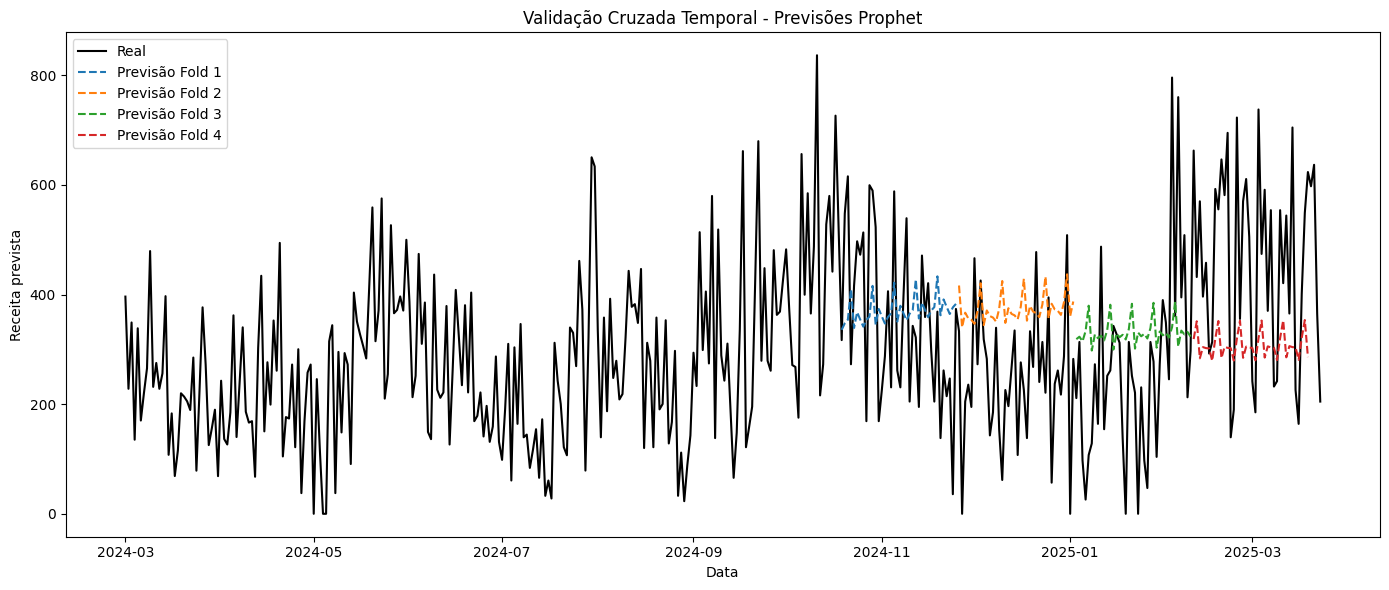

In [72]:
# Visualização das Previsões por Fold

plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Real', color='black')

for i in range(len(metricas_prophet)):
    inicio = tamanho_inicial_treino + i * horizonte_previsao
    fim = inicio + horizonte_previsao
    if fim > len(df_prophet):
        break
    df_treino = df_prophet.iloc[:inicio]
    df_teste = df_prophet.iloc[inicio:fim]

    previsao = treinar_e_prever_prophet(df_treino, df_teste)

    plt.plot(df_teste['ds'], previsao['yhat'], label=f'Previsão Fold {i+1}', linestyle='--')

plt.title('Validação Cruzada Temporal - Previsões Prophet')
plt.xlabel('Data')
plt.ylabel('Receita prevista')
plt.legend()
plt.tight_layout()
plt.show()


Esse gráfico mostra a validação cruzada temporal usando o Prophet para prever a receita diária de vendas de café. Os principais pontos:

Linha preta (Real): Representa a série temporal real de receita diária ao longo do tempo.

Linhas tracejadas coloridas: Cada cor representa as previsões do Prophet para um fold (janela) diferente da validação cruzada temporal. Por exemplo, "Previsão Fold 1", "Previsão Fold 2" etc.

Sobreposição: As previsões de cada fold aparecem apenas nos períodos de teste correspondentes, sem sobrepor os dados de treino.

Aderência: As previsões seguem a tendência geral dos dados reais, mas suavizam as oscilações mais bruscas, característica comum do Prophet.

Variação entre folds: É possível observar pequenas diferenças entre as previsões dos folds, o que é esperado, pois cada fold utiliza um período de treino diferente.


O gráfico ilustra bem como o Prophet se comporta em diferentes janelas de teste. Ele mostra que o modelo consegue capturar a tendência e parte da sazonalidade, mas suaviza os picos e vales mais extremos. Isso é típico de modelos robustos para séries temporais, que priorizam o padrão geral em vez de oscilações pontuais. A visualização é útil para avaliar a estabilidade e a capacidade preditiva do modelo ao longo do tempo.

### Remoção de Tendência e/ou Sazonalidade Para implementar no modelo ARIMA

In [73]:
# Teste Aumentado de Dickey-Fuller para verificar estacionaridade
resultado_adf = adfuller(serie)

print(f'Estatística ADF: {resultado_adf[0]}')
print(f'Valor-p: {resultado_adf[1]}')
print('Valores Críticos:')
for chave, valor in resultado_adf[4].items():
    print(f'\t{chave}: {valor}')

if resultado_adf[1] <= 0.05:
    print("\nA série é estacionária (rejeitamos a hipótese nula).")
else:
    print("\nA série NÃO é estacionária (não rejeitamos a hipótese nula).")

Estatística ADF: -3.049677810984979
Valor-p: 0.030508413587781693
Valores Críticos:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181

A série é estacionária (rejeitamos a hipótese nula).


Interpretação do resultado do Teste ADF:

Estatística ADF: Quanto mais negativa, maior a probabilidade de a série ser estacionária.

Valor-p: É o mais importante. Se o valor-p for menor ou igual a um nível de significância (geralmente 0.05), rejeitamos a hipótese nula e concluímos que a série é estacionária.

Valores Críticos: São limiares para comparar a Estatística ADF em diferentes níveis de confiança. Se a Estatística ADF for menor que o valor crítico em um determinado nível de confiança, a série é considerada estacionária nesse nível.

Análise de ACF e PACF  para ajudar a determinar os parâmetros p e q do modelo ARIMA.

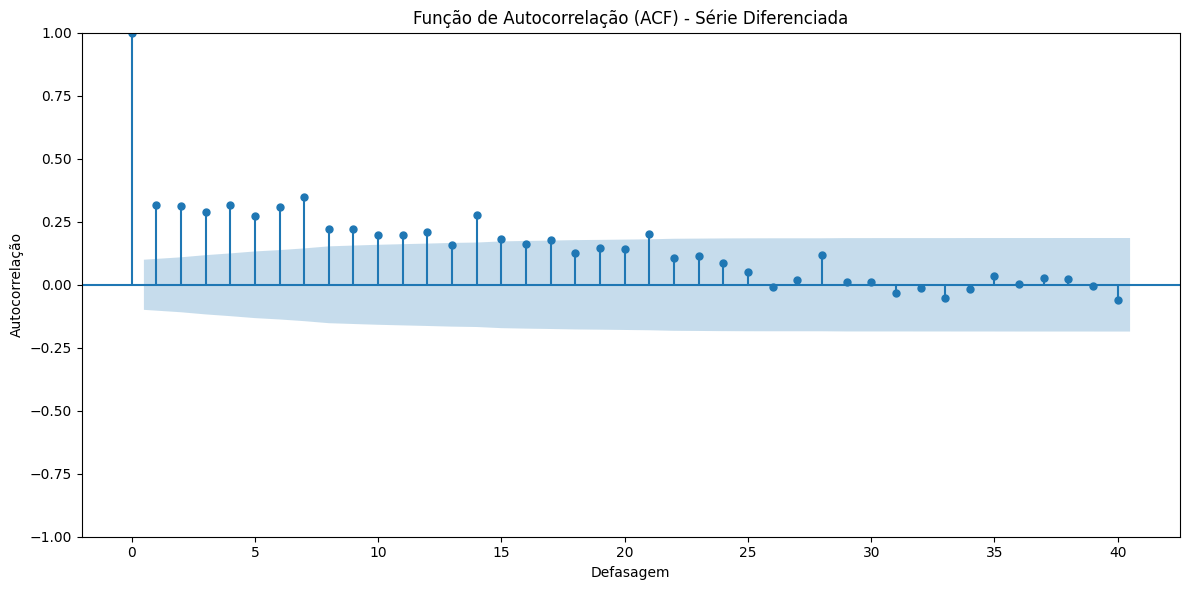

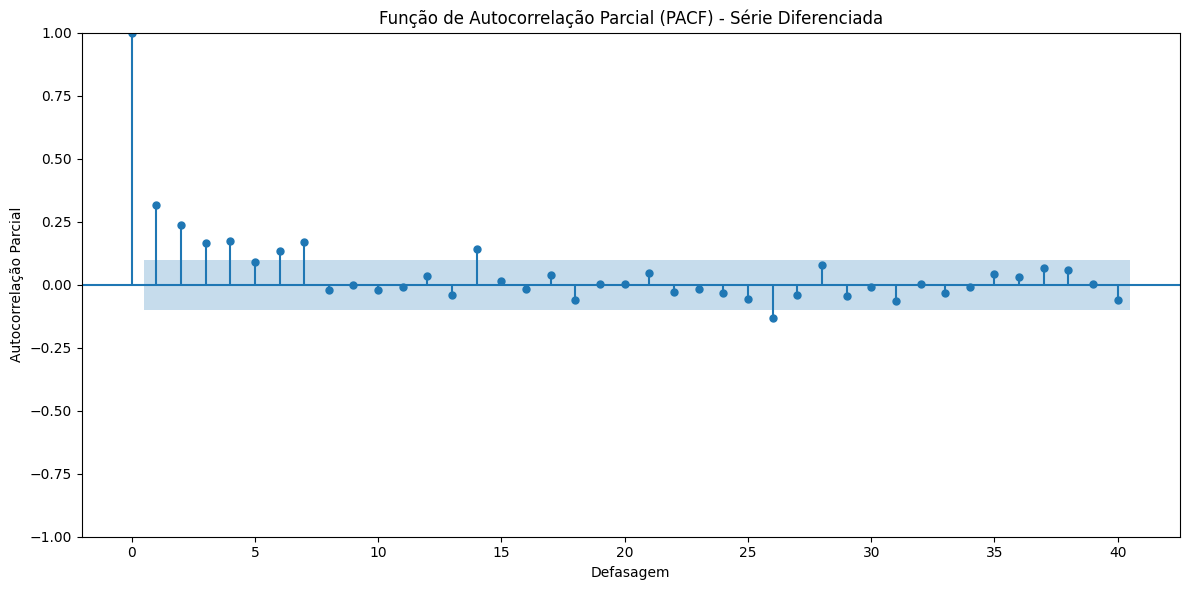

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotagem do ACF para a série diferenciada
plt.figure(figsize=(12, 6))
plot_acf(serie, lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação (ACF) - Série Diferenciada')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.tight_layout()
plt.show()

# Plotagem do PACF para a série diferenciada
plt.figure(figsize=(12, 6))
plot_pacf(serie, lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação Parcial (PACF) - Série Diferenciada')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.tight_layout()
plt.show()

Procuramos um "corte abrupto" onde as barras significativas (aquelas que ultrapassam a área sombreada azul) param de repente após um certo número de defasagens.

No gráfico ACF da série:

Interpretação:

Defasagem 1: Há uma barra significativa na defasagem 1, indicando forte autocorrelação entre o valor atual e o valor imediatamente anterior. Isso é comum em séries temporais e sugere que o termo de média móvel (q) deve ser considerado no modelo ARIMA.

Decaimento rápido: Após a defasagem 1, observa-se um decaimento relativamente rápido das autocorrelações, o que reforça a indicação de q=1 para o componente não sazonal do ARIMA.

Sazonalidade semanal: Existem barras significativas em defasagens múltiplas de 7 (como 7, 14, 21, etc.), sugerindo a presença de uma sazonalidade semanal na série, mesmo após a diferenciação.

Barras dentro da faixa azul: A maioria das barras após as primeiras defasagens está dentro da faixa azul (intervalo de confiança), indicando que não há autocorrelação significativa nessas defasagens.

Resumo:

O gráfico sugere que um modelo ARIMA com q=1 pode ser adequado para o componente não sazonal, mas a presença de autocorrelação em múltiplos de 7 indica que um modelo SARIMA, que incorpora sazonalidade semanal, pode melhorar o ajuste e a previsão da série.

No gráfico PACF da serie:

Interpretação:

Defasagem 1: Há uma barra significativa na defasagem 1, indicando que o valor atual da série tem forte relação apenas com o valor imediatamente anterior, após a diferenciação.

Corte abrupto: Após a defasagem 1, as barras caem rapidamente e ficam dentro da faixa azul (intervalo de confiança), sugerindo que não há autocorrelação parcial significativa em defasagens maiores.

Sugestão de parâmetro: Esse padrão indica que o parâmetro p=1 é adequado para o componente não sazonal do modelo ARIMA.

Sazonalidade: Não há evidências claras de sazonalidade semanal no PACF, pois não há barras significativas em múltiplos de 7.

Resumo:

O gráfico PACF sugere que um modelo ARIMA com p=1 é apropriado, pois a autocorrelação parcial é significativa apenas na primeira defasagem e se dissipa rapidamente nas demais.

Com base na análise visual:

d: O teste ADF na série diferenciada sugeriu que d=1 é apropriado.
p: O corte abrupto no PACF na defasagem 1 sugere p=1.
q: O corte abrupto no ACF na defasagem 1 sugere q=1.
Portanto, uma ordem inicial razoável para o modelo ARIMA seria (1, 1, 1).

### Divisão dos Dados e Modelagem para o ARIMA

In [78]:
# Função para treinar e prever com ARIMA

def treinar_e_prever_arima(serie_treino, serie_teste, order):
    # O modelo ARIMA assume que a série de entrada é a série original
    # e o parâmetro 'order' lida com a diferenciação
    modelo = ARIMA(serie_treino, order=order)
    resultado = modelo.fit()

    # O método forecast() prevê para o número especificado de passos à frente
    previsao = resultado.forecast(steps=len(serie_teste))

    # Retornar um DataFrame similar ao do Prophet para facilitar a comparação
    previsao_df = pd.DataFrame({
        'ds': serie_teste.index,
        'yhat': previsao.values # previsao.values contém os valores previstos
    })
    return previsao_df

In [79]:
# Ordem do modelo ARIMA com base na análise de ACF/PACF e ADF
ordem_arima_definida = (1, 1, 1)

# Validação Cruzada Temporal com Métricas para ARIMA

# Parâmetros da validação cruzada
tamanho_inicial_treino = int(len(serie) * 0.6) # Usando o tamanho da série original
horizonte_previsao = int(len(serie) * 0.1)   # Usando o tamanho da série original

metricas_arima = [] # Lista para as métricas do ARIMA

# Validação cruzada temporal
# Loop sobre os índices da série original
for i in range(tamanho_inicial_treino, len(serie) - horizonte_previsao, horizonte_previsao):

    # Para o ARIMA, precisamos da série temporal na escala original (objeto Series do pandas)
    # O objeto 'serie' já está com o índice de data e valores agregados diariamente
    serie_treino_arima = serie.iloc[:i]
    serie_teste_arima = serie.iloc[i:i + horizonte_previsao]

    # Previsão com ARIMA
    try:
        previsao_arima = treinar_e_prever_arima(serie_treino_arima, serie_teste_arima, ordem_arima_definida)
        # Comparar com os valores reais da série_teste_arima (objeto Series)
        mae_arima = mean_absolute_error(serie_teste_arima.values, previsao_arima['yhat'])
        rmse_arima = np.sqrt(mean_squared_error(serie_teste_arima.values, previsao_arima['yhat']))
        metricas_arima.append({'mae': mae_arima, 'rmse': rmse_arima})
        print(f"Iteração {len(metricas_arima)} - ARIMA (MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f})")
    except Exception as e:
        # Tratar possíveis erros durante o treinamento do ARIMA (pode acontecer com certas ordens ou dados)
        print(f"Erro ao treinar ou prever com ARIMA na iteração {len(metricas_arima) + 1}: {e}")
        metricas_arima.append({'mae': np.nan, 'rmse': np.nan}) # Adicionar NaN para não quebrar o cálculo da média

# Cálculo das métricas médias
mae_medio_arima = np.nanmean([m['mae'] for m in metricas_arima]) # Usar nanmean para ignorar NaNs se houver erros
rmse_medio_arima = np.nanmean([m['rmse'] for m in metricas_arima])

print("\nMétricas Médias com Validação Cruzada Temporal para ARIMA:")
print(f"MAE Médio: {mae_medio_arima:.2f}")
print(f"RMSE Médio: {rmse_medio_arima:.2f}")

Iteração 1 - ARIMA (MAE: 183.18, RMSE: 218.05)
Iteração 2 - ARIMA (MAE: 89.54, RMSE: 117.99)
Iteração 3 - ARIMA (MAE: 122.72, RMSE: 172.44)
Iteração 4 - ARIMA (MAE: 164.96, RMSE: 189.90)

Métricas Médias com Validação Cruzada Temporal para ARIMA:
MAE Médio: 140.10
RMSE Médio: 174.60


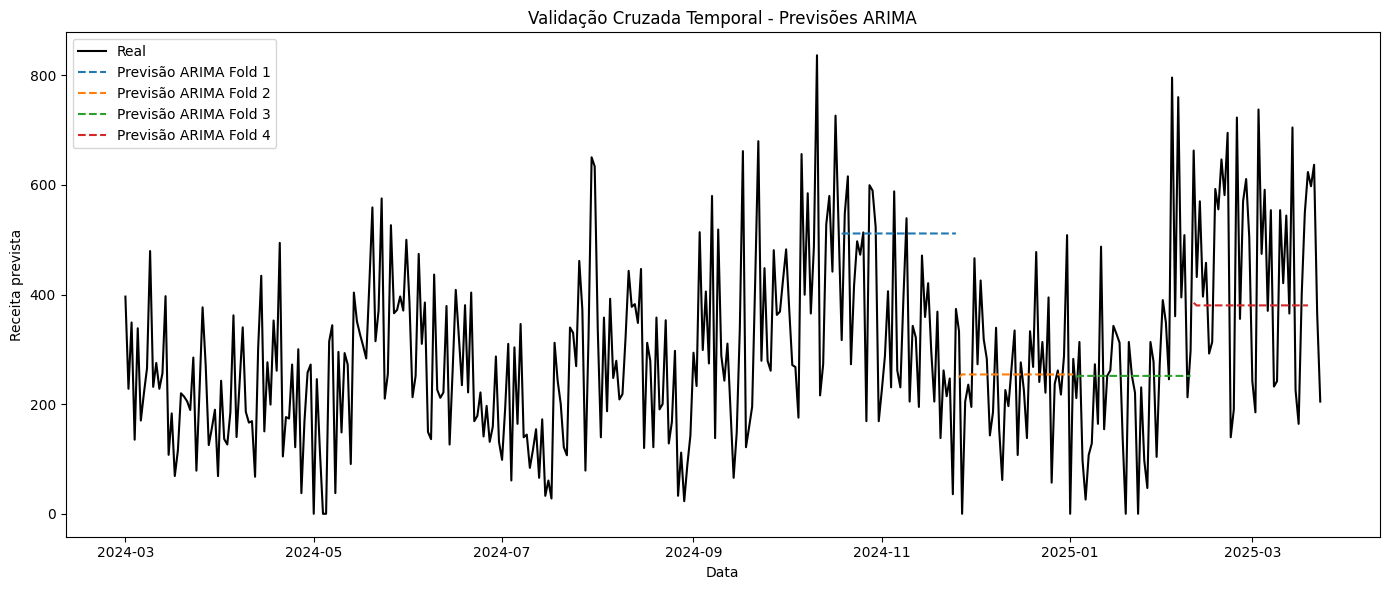

In [80]:
# Visualização das Previsões por Fold para ARIMA

plt.figure(figsize=(14, 6))
# Plotar a série real completa para referência
plt.plot(serie.index, serie.values, label='Real', color='black')

# Parâmetros da validação cruzada (certifique-se de que são os mesmos usados na avaliação)
tamanho_inicial_treino = int(len(serie) * 0.6)
horizonte_previsao = int(len(serie) * 0.1)
ordem_arima_definida = (1, 1, 1) # Use a ordem que você definiu

# Loop para gerar previsões em cada fold e plotar
# O loop itera sobre os índices da série original
fold_count = 0 # Contador para o número do fold
for i in range(tamanho_inicial_treino, len(serie) - horizonte_previsao, horizonte_previsao):
    fold_count += 1
    inicio = i
    fim = i + horizonte_previsao

    # Certificar-se de que o fold de teste não ultrapassa o tamanho da série
    if fim > len(serie):
        break

    # Extrair dados de treino e teste para o fold atual
    serie_treino_arima = serie.iloc[:inicio]
    serie_teste_arima = serie.iloc[inicio:fim]

    # Gerar previsões para o fold de teste
    try:
        previsao_arima = treinar_e_prever_arima(serie_treino_arima, serie_teste_arima, ordem_arima_definida)

        # Plotar as previsões do ARIMA para o fold atual
        # Use um rótulo único para cada fold
        plt.plot(previsao_arima['ds'], previsao_arima['yhat'], label=f'Previsão ARIMA Fold {fold_count}', linestyle='--')

    except Exception as e:
        print(f"Erro ao gerar previsão para plotagem do ARIMA no Fold {fold_count}: {e}")
        # Se ocorrer um erro, não plotamos este fold

plt.title('Validação Cruzada Temporal - Previsões ARIMA')
plt.xlabel('Data')
plt.ylabel('Receita prevista')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretação do Gráfico de Validação Cruzada Temporal - Previsões ARIMA

O gráfico apresenta a validação cruzada temporal das previsões do modelo ARIMA para a receita diária de vendas de café.

- **Linha preta (Real):** Representa a série temporal real da receita diária ao longo do tempo.
- **Linhas tracejadas coloridas:** Cada cor corresponde às previsões do ARIMA para um fold (janela de teste) diferente da validação cruzada temporal, como "Previsão ARIMA Fold 1", "Fold 2" etc.
- **Cada fold:** O modelo é treinado até certo ponto da série e faz previsões para o próximo intervalo (horizonte de previsão). Isso é repetido em diferentes pontos da série, simulando previsões em diferentes períodos históricos.
- **Sobreposição:** As previsões aparecem apenas nos períodos de teste de cada fold, sem sobrepor os dados de treino.

#### O que o gráfico mostra:

- O ARIMA consegue capturar a tendência geral da série, mas suaviza as oscilações mais bruscas.
- As previsões de cada fold são feitas apenas para o período de teste correspondente, mostrando como o modelo se comporta em diferentes momentos históricos.
- Pequenas diferenças entre as previsões dos folds são esperadas, pois cada um utiliza um período de treino diferente.

O gráfico é útil para avaliar a **estabilidade** e a **capacidade preditiva** do ARIMA ao longo do tempo. Ele mostra que o modelo tende a seguir o padrão geral da série, mas pode não capturar picos e vales extremos, o que é típico de modelos ARIMA em séries com alta variabilidade. Isso reforça a importância de comparar com outros modelos e ajustar os parâmetros conforme necessário.

As linhas tracejadas aparecem retas porque, para cada janela de teste, o ARIMA faz previsões que mudam pouco entre os dias previstos daquele fold. Isso é um comportamento comum do ARIMA em previsões multi-passos, especialmente em séries com alta variabilidade e modelos simples.

Por isso abaixo foi feito previsões mais dinâmicas, reduzindo o horizonte de previsão (previsão de 1 passo por vez). E comparando os modelos.

### Compararação do desempenho dos modelos em um horizonte de previsão de 1 passo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/i18yamke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qconf5y/h_kxftzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74573', 'data', 'file=/tmp/tmp9qconf5y/i18yamke.json', 'init=/tmp/tmp9qconf5y/h_kxftzm.json', 'output', 'file=/tmp/tmp9qconf5y/prophet_modelsa9mg411/prophet_model-20250516202817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit


Métricas de Desempenho - Previsão de 1 Passo:
Prophet:
MAE: 139.52
RMSE: 173.14

ARIMA:
MAE: 125.65
RMSE: 159.31


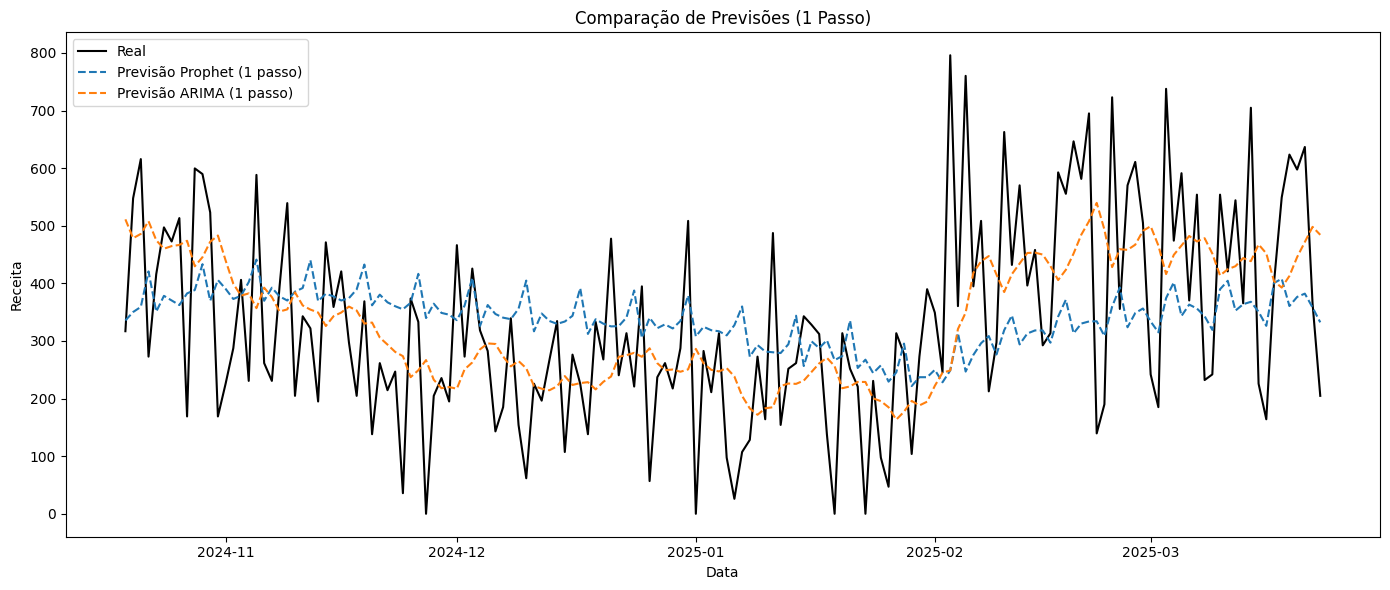

In [81]:
# Comparação de Desempenho - Previsão de 1 Passo

# Definir o tamanho inicial do treino (pode ser o mesmo da validação cruzada ou um valor fixo)
tamanho_inicial_treino_1_passo = int(len(serie) * 0.6) # Ou outro valor apropriado

previsoes_reais_1_passo = []
previsoes_prophet_1_passo = []
previsoes_arima_1_passo = []

# Loop para previsão de 1 passo
# Começa onde termina o tamanho inicial do treino
for i in range(tamanho_inicial_treino_1_passo, len(serie)):

    # Obter dados de treino para o passo atual
    df_treino_prophet = df_prophet.iloc[:i]
    serie_treino_arima = serie.iloc[:i]

    # Obter o valor real do próximo passo
    if i < len(serie):
        valor_real_proximo_passo = serie.iloc[i]
        data_proximo_passo = serie.index[i]
    else:
        # Isso só aconteceria se o loop chegasse ao fim da série
        break # Sair do loop se não houver mais dados reais para comparar

    # Armazenar o valor real
    previsoes_reais_1_passo.append({'ds': data_proximo_passo, 'y': valor_real_proximo_passo})

    # Prever 1 passo à frente com Prophet
    try:
        # Prophet precisa de um DataFrame de futuro com a data do próximo passo
        futuro_prophet_1_passo = pd.DataFrame({'ds': [data_proximo_passo]})
        previsao_prophet = Prophet().fit(df_treino_prophet).predict(futuro_prophet_1_passo)
        previsoes_prophet_1_passo.append({'ds': data_proximo_passo, 'yhat': previsao_prophet['yhat'].iloc[0]})
    except Exception as e:
        print(f"Erro ao prever 1 passo com Prophet na data {data_proximo_passo}: {e}")
        previsoes_prophet_1_passo.append({'ds': data_proximo_passo, 'yhat': np.nan})


    # Prever 1 passo à frente com ARIMA
    try:
        # ARIMA prevê o número especificado de passos à frente (aqui 1)
        modelo_arima_1_passo = ARIMA(serie_treino_arima, order=ordem_arima_definida)
        resultado_arima_1_passo = modelo_arima_1_passo.fit()
        previsao_arima = resultado_arima_1_passo.forecast(steps=1)
        previsoes_arima_1_passo.append({'ds': data_proximo_passo, 'yhat': previsao_arima.iloc[0]}) # ARIMA forecast retorna uma Series ou array
    except Exception as e:
        print(f"Erro ao prever 1 passo com ARIMA na data {data_proximo_passo}: {e}")
        previsoes_arima_1_passo.append({'ds': data_proximo_passo, 'yhat': np.nan})


# Converter listas de previsões para DataFrames para facilitar o cálculo de métricas
df_reais_1_passo = pd.DataFrame(previsoes_reais_1_passo).set_index('ds')
df_prophet_1_passo = pd.DataFrame(previsoes_prophet_1_passo).set_index('ds')
df_arima_1_passo = pd.DataFrame(previsoes_arima_1_passo).set_index('ds')

# Juntar os DataFrames para garantir que as comparações sejam feitas nas mesmas datas
df_comparacao_1_passo = df_reais_1_passo.join(df_prophet_1_passo, rsuffix='_prophet').join(df_arima_1_passo, rsuffix='_arima').dropna()


# Calcular métricas de avaliação para previsão de 1 passo
mae_prophet_1_passo = mean_absolute_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat'])
rmse_prophet_1_passo = np.sqrt(mean_squared_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat']))

mae_arima_1_passo = mean_absolute_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat_arima']) # Usar 'yhat_arima' após o join
rmse_arima_1_passo = np.sqrt(mean_squared_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat_arima']))


print("\nMétricas de Desempenho - Previsão de 1 Passo:")
print("Prophet:")
print(f"MAE: {mae_prophet_1_passo:.2f}")
print(f"RMSE: {rmse_prophet_1_passo:.2f}")
print("\nARIMA:")
print(f"MAE: {mae_arima_1_passo:.2f}")
print(f"RMSE: {rmse_arima_1_passo:.2f}")

# Opcional: Visualizar as previsões de 1 passo
plt.figure(figsize=(14, 6))
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['y'], label='Real', color='black')
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['yhat'], label='Previsão Prophet (1 passo)', linestyle='--')
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['yhat_arima'], label='Previsão ARIMA (1 passo)', linestyle='--')
plt.title('Comparação de Previsões (1 Passo)')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretação do Gráfico de Comparação de Previsões (1 Passo)

O gráfico apresenta a comparação entre as previsões de 1 passo à frente dos modelos Prophet e ARIMA em relação à série real de receita diária de vendas de café.

- **Linha preta (Real):** Representa a receita diária real ao longo do tempo.
- **Linha azul tracejada (Prophet):** Mostra a previsão do modelo Prophet para cada dia, sempre prevendo apenas o próximo valor.
- **Linha laranja tracejada (ARIMA):** Mostra a previsão do modelo ARIMA para cada dia, também prevendo apenas o próximo valor.

#### O que o gráfico mostra:

- Ambos os modelos suavizam bastante as oscilações reais: as linhas de previsão são menos voláteis que a linha real, indicando que os modelos capturam a tendência geral, mas não conseguem prever os picos e vales mais extremos.
- **Prophet (azul):** Apresenta uma previsão mais estável, acompanhando a tendência central da série, mas com pouca resposta às variações rápidas.
- **ARIMA (laranja):** Também suaviza, mas em alguns momentos acompanha melhor as mudanças de patamar da série, embora ainda não capture os extremos.
- Nenhum dos modelos consegue prever as oscilações diárias abruptas, mas ambos acompanham a tendência de subida ou descida ao longo do tempo.

O gráfico evidencia que, para previsão de 1 passo, tanto Prophet quanto ARIMA conseguem seguir a tendência geral da receita, mas **não são capazes de antecipar as variações bruscas do dia a dia**.

## Conclusão Final: Comparação dos Modelos Prophet e ARIMA

Com base nos gráficos e nas métricas apresentadas, é possível tirar as seguintes conclusões sobre o desempenho dos modelos Prophet e ARIMA na previsão da receita diária de vendas de café:

### 1. Desempenho Quantitativo (Métricas)

- **Previsão de 1 Passo à Frente:**
  - **Prophet:** MAE = 139,52 | RMSE = 173,14
  - **ARIMA:** MAE = 125,65 | RMSE = 159,31

- **Validação Cruzada Temporal (Médias):**
  - **Prophet:** MAE Médio = 151,76 | RMSE Médio = 183,31
  - **ARIMA:** MAE Médio = 140,10 | RMSE Médio = 174,60

**Interpretação:**  
O modelo ARIMA apresentou desempenho quantitativo ligeiramente superior ao Prophet em todas as métricas avaliadas (MAE e RMSE), tanto na previsão de 1 passo quanto na validação cruzada temporal. Isso indica que o ARIMA conseguiu gerar previsões um pouco mais próximas dos valores reais da série.

### 2. Análise Visual dos Gráficos

- Ambos os modelos conseguem capturar a **tendência geral** da série temporal, mas **suavizam as oscilações** e não conseguem prever picos e vales extremos.
- O Prophet apresenta previsões mais estáveis e suavizadas, enquanto o ARIMA, apesar de também suavizar, acompanha um pouco melhor as mudanças de patamar da série.
- Nas previsões multi-passos (validação cruzada temporal), as linhas de previsão tendem a ser quase retas, mostrando a limitação dos modelos em antecipar variações rápidas.

### 3. Considerações Finais

- **ARIMA se mostrou ligeiramente mais adequado para esta série temporal**, considerando as métricas de erro e a aderência visual às tendências da série.
- Ambos os modelos têm limitações para capturar variações abruptas do dia a dia, o que é comum em séries temporais com alta variabilidade.
- Para melhorar a previsão dos picos e vales, pode ser interessante testar modelos mais complexos, incorporar variáveis externas ou ajustar os parâmetros dos modelos.

**Resumo:**  
O ARIMA apresentou desempenho geral um pouco melhor para a previsão da receita diária de vendas de café, mas tanto ARIMA quanto Prophet são eficazes para capturar tendências, sendo menos eficientes para prever oscilações bruscas. A escolha entre eles pode depender do objetivo da previsão e da necessidade de interpretar componentes como tendência e sazonalidade.

Proximo passo testar modelos mais complexos ou modificar os parametros para um melhor resultado.